<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>DLMI Kaggle challenge</h1></center>
<center>Maxime RIGHINI, Nicolas GREVET</center>
<center><h2>Part 5 - Prediction with classification models</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


The purpose of this notebook is to predict the isup_grade of the test set with classification models. <br>
The predictions of the regression and classification models will then be averaged for the final prediction.

> The structure of this notebook is as follows: 
>> I - [Import of libraries and raw dataset](#imports)
>>
>>
>> II - [Creation and visualization of the pytorch dataset](#preparation)
>>
>>
>> III - [Model training](#train)
>>
>>
>> IV - [Prediction](#predi)

# I - <a name="imports"></a> Import of libraries and raw dataset

We start by installing and importing the libraries that we will need throughout the notebook.

In [ ]:
! pip install -q imagecodecs
! pip install -q warmup_scheduler
! pip install -q efficientnet_pytorch

In [2]:
from google.colab import drive 
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings("ignore")

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from tqdm import tqdm
tqdm.pandas()

# Deep learning model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold

Then we import the training data (the train dataframe to which we added the tiles during the preprocessing step - each slide is 100 tiles of size (128, 128, 3)).
> Note that by exporting the tiles, the arrays have been transformed into strings. We must therefore convert them back (this is the purpose of the *progress_apply*).

In [ ]:
df = pd.read_csv("drive/MyDrive/DLMI/train_with_tiles.csv")
df["tiles"] = df["tiles"].progress_apply(lambda x : np.array(x.replace("[", "").replace("]", "").split(",")).astype(np.int16).reshape(100, 128, 128, 3))

100%|██████████| 340/340 [14:31<00:00,  2.56s/it]


Here we use the prediction made in part 3 to try to eliminate slides with incorrect labels. <br>
We choose a threshold of 1.7 because it allows to eliminate about 10% of the slides.

In [ ]:
df_pred = pd.read_csv("drive/MyDrive/DLMI/train_clean.csv")
images_to_keep = df_pred[abs(df_pred["isup_grade"]-df_pred["out_of_fold_predictions"]) <= 1.7]["image_id"].values
print("{} images are kept".format(len(images_to_keep)))
df_clean = df[df["image_id"].isin(images_to_keep)].reset_index(drop=True)

299 images are kept


# II - <a name="preparation"></a> Creation and visualization of the pytorch dataset

We create the dataset as in the label cleaning notebook.
> Here, we convert the labels to use the loss function `BCEWithLogitsLoss`. isup_grade 0 is converted to [0, 0, 0, 0, 0], isup_grade 3 is converted to [1, 1, 1, 0, 0] etc...

In [ ]:
class PANDADataset(Dataset):
    def __init__(self, df, image_size=128, n_tiles=100, transform=None,):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index, image_size=128):
        row = self.df.iloc[index]
        tiles = row.tiles
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > i:
                    this_img = tiles[i]
                else:
                    this_img = np.zeros((self.image_size, self.image_size, 3)).astype(np.uint8)
                # Application of the augmentation on the tile level
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        # Application of the augmentation on the whole slide level
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        # Get the label and convert it
        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        # The function returns the image and the converted label of the image
        return torch.tensor(images), torch.tensor(label)

The rest of this part is similar to the label cleaning notebook.

In [ ]:
transforms_train = albumentations.Compose([albumentations.HorizontalFlip(p=0.5),
                                           albumentations.VerticalFlip(p=0.5),
                                           albumentations.Transpose(p=0.5)])

transforms_val = albumentations.Compose([])

In [ ]:
dataset_show = PANDADataset(df, transform=transforms_train)

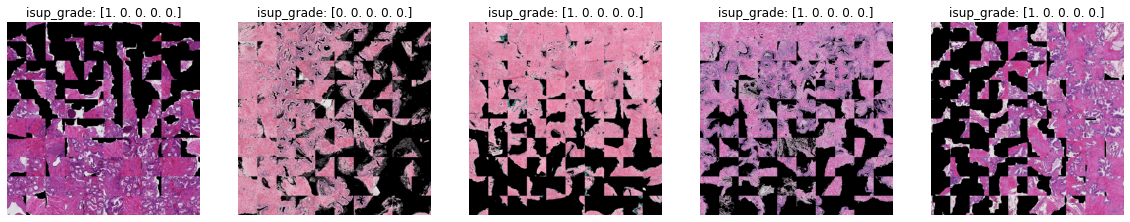

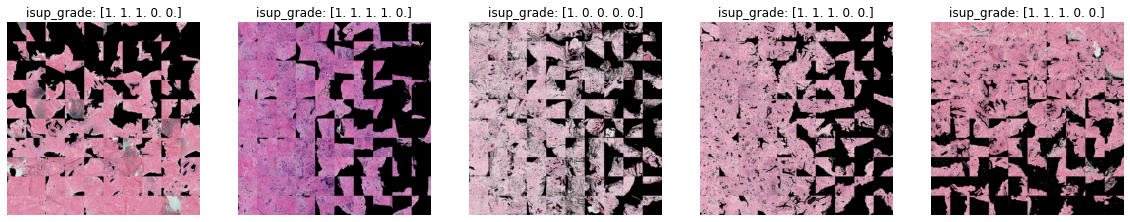

In [ ]:
rcParams["figure.figsize"] = 20, 10
for i in range(2):
    f, axarr = plt.subplots(1, 5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title("isup_grade: "+str(label.numpy()))
        axarr[p].axis("off")

# III - <a name="train"></a> Model training

In this part, we split the training data into 5 folds. <br>
For each validation fold we will train an efficient-b0 classification model 2 times 
> - One time on the full dataset.
>
>
> - One time on the "clean" dataset.
We save the weights of each model, and we will make the prediction in the next part.

First, let's create the folds.

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=123)

df["fold"] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df, df["isup_grade"])):
    df.loc[valid_idx, "fold"] = i

df_clean["fold"] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_clean, df_clean["isup_grade"])):
    df_clean.loc[valid_idx, "fold"] = i

We use the same training function as in the label cleaning notebook, but without the test_fold now.

In [ ]:
def train(num_epochs, batch_size, criterion, optimizer, model, df, df_name, fold):

    train_idx = np.where((df["fold"] != fold))[0] # Avoid valid fold for the training
    valid_idx = np.where((df["fold"] == fold))[0] # Use valid fold for the validation

    # Create the pytorch datasets (with the right augmentations)
    dataset_train = PANDADataset(df.loc[train_idx], transform=transforms_train)
    dataset_valid = PANDADataset(df.loc[valid_idx], transform=transforms_val)

    # Create the loaders from the pytorch datasets
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=4)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=4)

    # We use a scheduler to reduce the batch size according to the epochs
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs-1)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    # Set a very big minimum validation loss so it is replaced after the first epoch
    val_loss_min = 1e20
        
    # Go through each epoch
    for epoch in range(1, num_epochs+1):
      
        # Training on the train_loader
        model.train()
        train_loss = []
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            loss_func = criterion
            optimizer.zero_grad()
            logits = model(data)
            loss = loss_func(logits, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
        train_loss = np.mean(train_loss)
        
        # Validation on the valid_loader
        model.eval()
        val_loss = []
        with torch.no_grad():
            for (data, target) in valid_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data)
                loss = criterion(logits, target)
                val_loss.append(loss.detach().cpu().numpy())
            val_loss = np.mean(val_loss)
        
        # Reduce the learning rate
        scheduler.step()

        # If the validation loss reaches a new low, replace the min validation loss and save the model
        if val_loss < val_loss_min:
            print('Epoch [{}/{}], Valid loss ({:.4f} --> {:.4f}).  Saving model ...'.format(epoch, num_epochs, val_loss_min, val_loss))
            torch.save(model.state_dict(), "efficientnet-b0_"+df_name+"_"+str(fold)+".pth")
            val_loss_min = val_loss

Then we train the models.

In [ ]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_pretrained(backbone)

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [ ]:
device = torch.device("cuda")
num_epochs = 30
batch_size = 4
init_lr = 3e-4
criterion = nn.BCEWithLogitsLoss()

saved_model_names = []

In [ ]:
for fold in range(5):
    print("########## fold "+str(fold)+" ##########")
    model = enetv2("efficientnet-b0", out_dim=5)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=init_lr/10)
    train(num_epochs, batch_size, criterion, optimizer, model, df, "df", fold)
    saved_model_names.append("efficientnet-b0_df_"+str(fold)+".pth")

########## fold 0 ##########
Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 0.6093).  Saving model ...
Epoch [2/30], Valid loss (0.6093 --> 0.4361).  Saving model ...
Epoch [4/30], Valid loss (0.4361 --> 0.3609).  Saving model ...
Epoch [8/30], Valid loss (0.3609 --> 0.3471).  Saving model ...
Epoch [12/30], Valid loss (0.3471 --> 0.3137).  Saving model ...
Epoch [22/30], Valid loss (0.3137 --> 0.2966).  Saving model ...
########## fold 1 ##########
Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 0.6440).  Saving model ...
Epoch [2/30], Valid loss (0.6440 --> 0.4209).  Saving model ...
Epoch [7/30], Valid loss (0.4209 --> 0.3421).  Saving model ...
Epoch [9/30], Valid loss (0.3421 --> 0.3292).  Saving model ...
Epoch [19/30], Valid loss (0.3292 --> 0.3201).  Saving model ...
########## fold 2 ##########
Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (10

In [ ]:
for fold in range(5):
    print("########## fold "+str(fold)+" ##########")
    model = enetv2("efficientnet-b0", out_dim=5)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=init_lr/10)
    train(num_epochs, batch_size, criterion, optimizer, model, df_clean, "df_clean", fold)
    saved_model_names.append("efficientnet-b0_df_clean_"+str(fold)+".pth")

########## fold 0 ##########
Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 0.6429).  Saving model ...
Epoch [2/30], Valid loss (0.6429 --> 0.5362).  Saving model ...
Epoch [3/30], Valid loss (0.5362 --> 0.3677).  Saving model ...
Epoch [4/30], Valid loss (0.3677 --> 0.3515).  Saving model ...
Epoch [5/30], Valid loss (0.3515 --> 0.3117).  Saving model ...
Epoch [7/30], Valid loss (0.3117 --> 0.3112).  Saving model ...
Epoch [10/30], Valid loss (0.3112 --> 0.3005).  Saving model ...
Epoch [12/30], Valid loss (0.3005 --> 0.2975).  Saving model ...
Epoch [15/30], Valid loss (0.2975 --> 0.2810).  Saving model ...
Epoch [17/30], Valid loss (0.2810 --> 0.2722).  Saving model ...
########## fold 1 ##########
Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 0.6333).  Saving model ...
Epoch [2/30], Valid loss (0.6333 --> 0.4376).  Saving model ...
Epoch [3/30], Valid loss (0.4376 --> 0

# IV - <a name="predi"></a> Prediction

We can finally make the predictions. each model does a prediction on each test image.

In [ ]:
df_test = pd.read_csv("drive/MyDrive/DLMI/test_with_tiles.csv")
df_test["tiles"] = df_test["tiles"].progress_apply(lambda x : np.array(x.replace("[", "").replace("]", "").split(",")).astype(np.int16).reshape(100, 128, 128, 3))

100%|██████████| 86/86 [03:28<00:00,  2.42s/it]


In [ ]:
class PANDADatasetPred(Dataset):
    def __init__(self, df, image_size=128, n_tiles=100, transform=None,):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index, image_size=128):
        row = self.df.iloc[index]
        tiles = row.tiles
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > i:
                    this_img = tiles[i]
                else:
                    this_img = np.zeros((self.image_size, self.image_size, 3)).astype(np.uint8)
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        return torch.tensor(images)

In [ ]:
prediction = pd.DataFrame({"image_id": df_test["image_id"].values}) # Ids of the test slides

for model_name in saved_model_names: # Go through each saved model
    prediction[model_name] = None # Create a new column for the prediction of this model
    # Prediction
    model = enetv2("efficientnet-b0", out_dim=5)
    model.load_state_dict(torch.load(model_name))
    dataset = PANDADatasetPred(df_test, transform=transforms_val)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SequentialSampler(dataset))
    model.eval()
    with torch.no_grad():
        i = 0
        for data in tqdm(loader):
            pred = model(data).sigmoid().sum(1).detach().numpy()[0]
            if pred < 0:
              pred = 0
            if pred > 5:
              pred = 5
            prediction.loc[i, model_name] = pred
            i += 1

Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:13<00:00,  1.56s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:13<00:00,  1.56s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:12<00:00,  1.54s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:12<00:00,  1.55s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:13<00:00,  1.55s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:13<00:00,  1.55s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:13<00:00,  1.55s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:13<00:00,  1.56s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:13<00:00,  1.56s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 86/86 [02:13<00:00,  1.55s/it]


In [ ]:
prediction.to_csv("prediction_classification.csv", index=False)